Planning a business trip from New York City to San Francisco.

Suppose there is a meeting scheduled at a specific time. How early should you plan to arrive to avoid being late due to flight delays?

Assume the 336,776 flights in the nycflights13 package represent the population

In [2]:
!pip install nycflights13
!pip install matplotlib
!pip install IPython
!pip install statsmodels
!pip install plotnine
from nycflights13 import flights

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.autolayout'] = True
plt.ioff()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nycflights13: filename=nycflights13-0.0.3-py3-none-any.whl size=8732722 sha256=ab17695f6aea7f7afd36915ac72322bcd7a60a7201066b06c1caec0b1d459de7
  Stored in directory: /root/.cache/pip/wheels/88/f8/a0/0cddecda19243434a89128b8fd0b4d58ce5747261751428873
Successfully built nycflights13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.0 MB/s eta 0:00:00


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.html.table_schema = True
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
SF = flights[(flights['dest'] == 'SFO') & (flights['arr_delay'].notna())]
np.random.seed(101)
sf_25 = SF.sample(n = 25)


Find the longest flight delay and adjust the travel schedule to accommodate it.

Of the 25 flights to SFO:
- Most were not late, and were ahead of schedule.
- But a few were very late, up to 72 minutes.
- The time spread was quite large (standard deviation 29 minutes).

In [5]:
stats = sf_25['arr_delay'].describe(percentiles=[0, 0.25, 0.5, 0.75, 1]).to_dict()
stats['na'] = sf_25['arr_delay'].isna().sum()
stats['n'] = len(sf_25['arr_delay'])
results = {
    'var': 'arr_delay',
    'n': stats['n'],
    'na': stats['na'],
    'mean': round(stats['mean'], 2),
    'sd': round(stats['std'], 2),
    'p0': round(stats['min'], 2),
    'p25': round(stats['25%'], 2),
    'p50': round(stats['50%'], 2),
    'p75': round(stats['75%'], 2),
    'p100': round(stats['max'], 2)
}
results_df = pd.DataFrame([results])
print(results_df)

         var   n  na  mean    sd     p0    p25    p50   p75  p100
0  arr_delay  25   0 -9.64 29.15 -64.00 -21.00 -13.00 -1.00 72.00


Arrive about 17 hours early? Traveling a day earlier incurs additional costs for lodging, meals, etc.
There’s no guarantee that delays longer than 1007 minutes won’t occur

A reasonable plan: balance cost-saving and the risk of being late — it’s acceptable to be late for only 2 out of 100 such business trips

- The average delay is 2.67 minutes (slightly late on average).
- Large standard deviation → very high variation in delays.
- Minimum value → there are flights arriving 86 minutes early.
- Quartile 1 → flights arrive earlier than 23 minutes.
- Median → half of flights arrive earlier than 8 minutes.
- Quartile 3 → 75% of flights arrive earlier than 12 minutes.
- Maximum value → flights are up to 1007 minutes late (~16.8 hours!).

Right-skewed distribution:
- Most flights arrive early or on time. But there are a few extreme cases of severe delays, such as 1007 minutes, which causes the mean to be positive (2.67).
- Importance of median (-8) vs. mean (2.67):
- Median is lower than mean → strengthens the evidence that the distribution is not symmetric and many flights arrive ahead of schedule.

In [6]:
stats_SF = SF['arr_delay'].describe(percentiles=[0, 0.25, 0.5, 0.75, 1]).to_dict()
stats_SF['na'] = SF['arr_delay'].isna().sum()
stats_SF['n'] = len(SF['arr_delay'])
results_SF = {
    'var': 'arr_delay',
    'n': stats_SF['n'],
    'na': stats_SF['na'],
    'mean': round(stats_SF['mean'], 2),
    'sd': round(stats_SF['std'], 2),
    'p0': int(stats_SF['min']),
    'p25': int(stats_SF['25%']),
    'p50': int(stats_SF['50%']),
    'p75': int(stats_SF['75%']),
    'p100': int(stats_SF['max'])
}
results_SF_df = pd.DataFrame([results_SF])
results_SF_df

,var,n,na,mean,sd,p0,p25,p50,p75,p100
0,arr_delay,13173,0,2.67,47.67,-86,-23,-8,12,1007


### Calculating the 98th Quantile of a Sample of 25 Rows (sf_25)

This means that 98% of the arrival delays in this sample sf_25 were less than 67.20 minutes.

In [7]:
q98_value = sf_25['arr_delay'].quantile(0.98)
q98_df = pd.DataFrame({'q98': [q98_value]})
q98_df.index = q98_df.index + 1
print(q98_df)

    q98
1 67.20


### Arrival Delay Distribution (True/False for arr_delay < 90)
Groups data based on whether the arrival delay (arr_delay) is less than 90 minutes or not (True/False).

If you planned to arrive 90 minutes early, how effective would that plan be in achieving the goal of being late to the meeting no more than 2% of the time?

- 95.1% of flights were delayed less than 90 minutes.
- 4.86% of flights were delayed more than 90 minutes.

In [8]:
grouped = SF.groupby(SF['arr_delay'] < 90).size().reset_index(name = 'n')
grouped.rename(columns={'arr_delay': 'arr_delay < 90'}, inplace = True)
grouped['pct'] = grouped['n'] / len(SF)
formats = {0: "{:.4f}", 1: "{:.3f}"}
grouped['pct'] = [formats[i].format(p) for i, p in enumerate(grouped['pct'])]

grouped.index = grouped.index + 1
print(grouped)

   arr_delay < 90      n     pct
1           False    640  0.0486
2            True  12533   0.951


### Calculating the 98th Quantile of All Data (SF)

That means 98% of flights to SFO are delayed less than 153 minutes.

In [9]:
q98_value_SF = SF['arr_delay'].quantile(0.98)
q98_value_SF = int(q98_value_SF)
q98_df_SF = pd.DataFrame({'q98': [q98_value_SF]})
q98_df_SF.index = q98_df_SF.index + 1
print(q98_df_SF)

   q98
1  153


### Taking a Random Sample of 25 Rows for 500 Trials

The result is a DataFrame sf_25_means that stores the average arrival delays of 500 trials of 25 random rows each.

- The mean_arr_delay column shows the average arrival delay for each random trial.
- The n column shows that each trial involves 25 rows.

In [10]:
n = 25 #Takes a random sample of 25 rows from the SF data.
num_trials = 500 #Performs this experiment 500 times.

sf_25_means = pd.DataFrame({
    'mean_arr_delay': [
        SF.sample(n = n).arr_delay.mean() #Calculates the mean of arr_delay for each sample.
        for _ in range(num_trials)
    ]
})

sf_25_means['n'] = n
sf_25_means.index = sf_25_means.index + 1
print(sf_25_means.head(6))

   mean_arr_delay   n
1            8.68  25
2            0.12  25
3            5.40  25
4            5.44  25
5           -3.16  25
6           17.48  25


From 500 trials with 25 random rows per trial, the average arrival delays show a fairly varied distribution, with most average delays being around 3 minutes.

The average delays tend to be positive, although there is quite a large variation, as the standard deviation reaches 9.85.

In [11]:
stats_25_SF = sf_25_means['mean_arr_delay'].describe(percentiles=[0, 0.25, 0.5, 0.75, 1]).to_dict()
stats_25_SF['na'] = sf_25_means['mean_arr_delay'].isna().sum()
stats_25_SF['n'] = len(sf_25_means['mean_arr_delay'])
results_25_SF = {
    'var': 'mean_arr_delay',
    'n': stats_25_SF['n'],
    'na': stats_25_SF['na'],
    'mean': round(stats_25_SF['mean'], 2),
    'sd': round(stats_25_SF['std'], 2),
    'p0': round(stats_25_SF['min'], 2),
    'p25': round(stats_25_SF['25%'], 2),
    'p50': round(stats_25_SF['50%'], 2),
    'p75': round(stats_25_SF['75%'], 2),
    'p100': round(stats_25_SF['max'], 2)
}
results_25_SF = pd.DataFrame([results_25_SF])
print(results_25_SF.to_string(index = False))

           var   n  na  mean   sd     p0   p25  p50  p75  p100
mean_arr_delay 500   0  3.06 9.85 -15.48 -3.93 1.70 8.73 35.72


### Calculating Confidence Intervals for Mean Delays
This means we can say with 95% confidence that the average delay across the population of flights to SFO is in the range of -16.64 minutes to 22.76 minutes. Since this range includes negative numbers, it shows that the data has a fairly varied distribution, including early flights.

In [12]:
x_bar = sf_25_means['mean_arr_delay'].mean()
se = sf_25_means['mean_arr_delay'].std()

ci_lower = x_bar - 2 * se
ci_upper = x_bar + 2 * se

summary_stats = pd.DataFrame({
    'x_bar': [x_bar],
    'se': [se],
    'ci_lower': [ci_lower],
    'ci_upper': [ci_upper]
})

summary_stats.index = summary_stats.index + 1
print(summary_stats)

   x_bar   se  ci_lower  ci_upper
1   3.06 9.85    -16.64     22.76


### Calculating the Average for a Sample of 100 Rows

We take 500 random samples of 100 rows each from the SF data and calculate the average arr_delay for each sample.

In [13]:
#A DataFrame that stores 500 average delays calculated from 500 samples of 100 rows.
n = 100
num_trials = 500

sf_100_means = pd.DataFrame({
    'mean_arr_delay': [
        SF.sample(n=n)['arr_delay'].mean()
        for _ in range(num_trials)
    ]
})

sf_100_means['n'] = n

### Combining Average Results from 25 and 100 Row Samples for Visualization

This histogram will show how the distribution of mean delays changes as the sample size increases from 25 to 100.

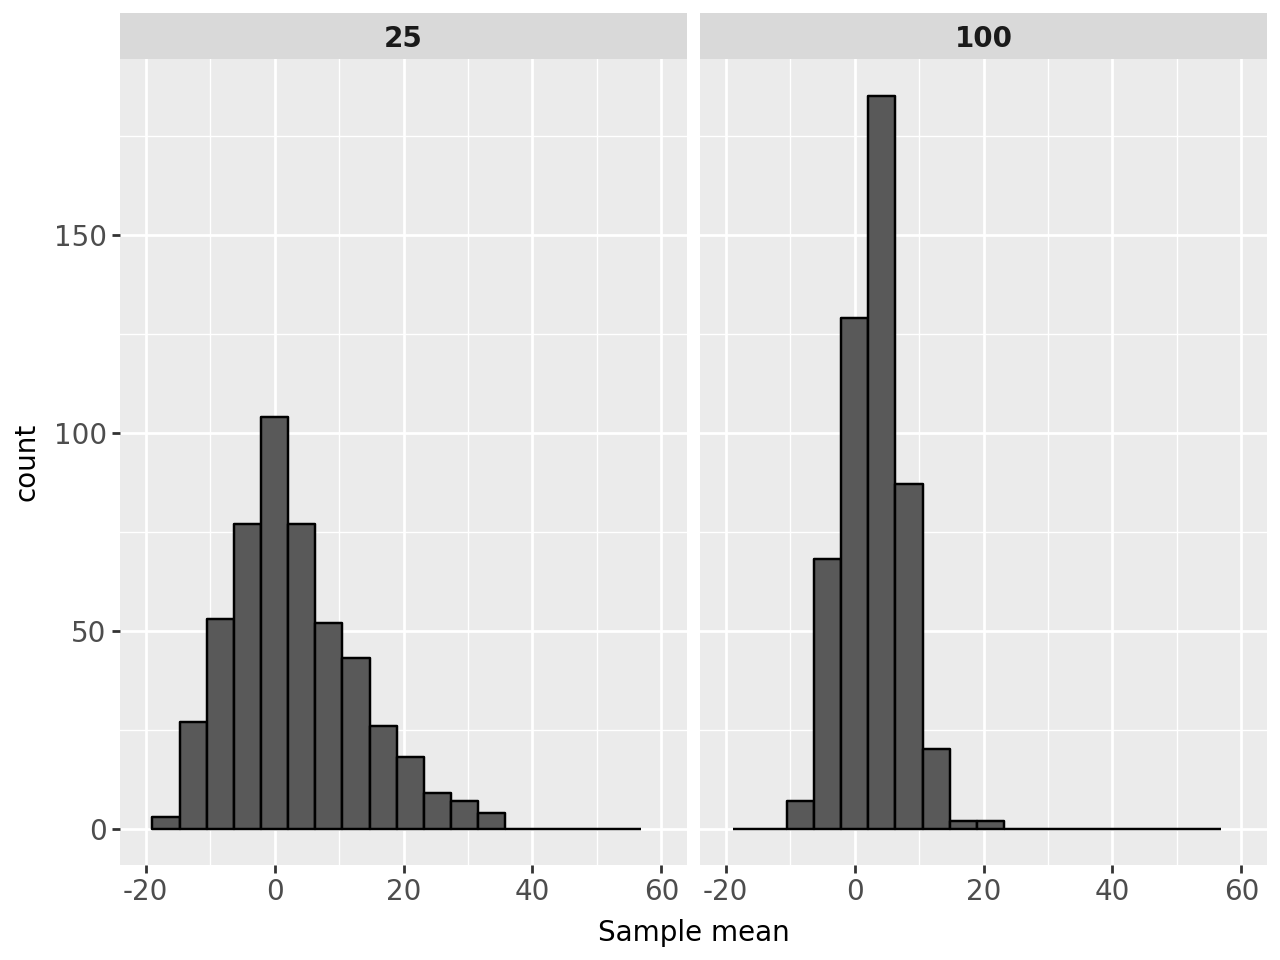

In [14]:
combined_means = pd.concat([sf_25_means, sf_100_means])
plot = (
    ggplot(combined_means, aes(x = 'mean_arr_delay')) +
    geom_histogram(bins = 20, color = "black") +
    facet_grid('. ~ n') + # produces two histograms separated by sample size (n = 25 and n = 100).
    labs(x = "Sample mean", y = "count") +
    xlim(-20, 60) + # Constrains the x-axis to display the range from -20 to 60 minutes.
    theme(axis_title = element_text(size = 10),
          axis_text = element_text(size = 10),
          strip_text_x = element_text(size = 10, weight = 'bold'))
)

plot.show()

### Displaying 3 random flights, with departure time information for each selected flight.

In [15]:
three_flights = SF.sample(n = 3, replace = False)[['year', 'month', 'day', 'dep_time']]
three_flights['dep_time'] = three_flights['dep_time'].astype(int)
three_flights.reset_index(inplace = True, drop = True)
three_flights.index = three_flights.index + 1
print(three_flights)

   year  month  day  dep_time
1  2013      9   13      1245
2  2013      5   19       841
3  2013      5   10      2133


In [16]:
three_flights_rep = SF.sample(n = 3, replace = True)[['year', 'month', 'day', 'dep_time']]
three_flights_rep['dep_time'] = three_flights_rep['dep_time'].astype(int)
three_flights_rep.reset_index(inplace = True, drop = True)
three_flights_rep.index = three_flights_rep.index + 1
print(three_flights_rep)

   year  month  day  dep_time
1  2013      1   20      1958
2  2013      9   28       627
3  2013     10    3      2144


### Bootstrap vs. Sampling Acak Biasa (n = 200)

Taken from bootstrap samples 500 times (with a return of 1 sample size 200).

More suitable for measuring the uncertainty of estimates from 1 sample.

In [17]:
n = 200
num_trials = 500

# Extract the original sample
orig_sample = SF.sample(n=n, replace=True)

# Calculate bootstrap statistics
bootstrap_results = pd.DataFrame({
    'mean_arr_delay': [
        orig_sample.sample(n=n, replace=True)['arr_delay'].mean()
        for _ in range(num_trials)
    ]
})

bootstrap_results['n'] = n

boot_skim = bootstrap_results['mean_arr_delay'].describe(percentiles=[0, 0.25, 0.5, 0.75, 1]).to_dict()
boot_skim['na'] = bootstrap_results['mean_arr_delay'].isna().sum()
boot_skim['n'] = len(bootstrap_results['mean_arr_delay'])
boot_skim_result = {
    'var': 'mean_arr_delay',
    'n': boot_skim['n'],
    'na': boot_skim['na'],
    'mean': round(boot_skim['mean'], 2),
    'sd': round(boot_skim['std'], 2),
    'p0': round(boot_skim['min'], 2),
    'p25': round(boot_skim['25%'], 2),
    'p50': round(boot_skim['50%'], 2),
    'p75': round(boot_skim['75%'], 2),
    'p100': round(boot_skim['max'], 2)
}
boot_skim_result = pd.DataFrame([boot_skim_result])
print(boot_skim_result.to_string(index = False))

           var   n  na  mean   sd    p0  p25  p50  p75  p100
mean_arr_delay 500   0  6.91 4.32 -4.91 4.16 6.64 9.85 24.64


### Ordinary Random Sampling – Mean arr_delay
Taken from 500 independent random samples from the population, each of size 200.

The mean is lower, indicating the original bootstrap sample likely had a higher lag than the population mean.

In [18]:
n = 200
num_trials = 500

sf_200_pop = pd.DataFrame({
    'mean_arr_delay': [SF.sample(n = n, replace=False)['arr_delay'].mean()
        for _ in range(num_trials)]})

sf_200_pop['n'] = n

sf_200_pop_skim = sf_200_pop['mean_arr_delay'].describe(percentiles=[0, 0.25, 0.5, 0.75, 1]).to_dict()
sf_200_pop_skim['na'] = sf_200_pop['mean_arr_delay'].isna().sum()
sf_200_pop_skim['n'] = len(sf_200_pop['mean_arr_delay'])
sf_200_pop_result = {
    'var': 'mean_arr_delay',
    'n': sf_200_pop_skim['n'],
    'na': sf_200_pop_skim['na'],
    'mean': round(sf_200_pop_skim['mean'], 2),
    'sd': round(sf_200_pop_skim['std'], 2),
    'p0': round(sf_200_pop_skim['min'], 2),
    'p25': round(sf_200_pop_skim['25%'], 2),
    'p50': round(sf_200_pop_skim['50%'], 2),
    'p75': round(sf_200_pop_skim['75%'], 2),
    'p100': round(sf_200_pop_skim['max'], 2)
}
sf_200_pop_result = pd.DataFrame([sf_200_pop_result])
print(sf_200_pop_result.to_string(index = False))

           var   n  na  mean   sd    p0  p25  p50  p75  p100
mean_arr_delay 500   0  2.45 3.25 -7.12 0.32 2.41 4.64 13.05


### Percentile ke-98 (q98) – arr_delay

Just 1 number, namely the 98th quantile of 1 bootstrap sample of size 200.

In [19]:
n = 200
orig_sample = SF.sample(n=n, replace=True)

q98 = orig_sample['arr_delay'].quantile(0.98)

q98_df = pd.DataFrame({'q98': [q98]})
q98_df.index = q98_df.index + 1
print(q98_df)

    q98
1 95.00


In [20]:
n = 200
orig_sample = SF.sample(n=n, replace=True)

num_trials = 500

sf_200_bs = pd.DataFrame({
    'q98': [
        orig_sample.sample(n=n, replace=True)['arr_delay'].quantile(0.98)
        for _ in range(num_trials)
    ]
})

### Bootstrap q98 (500 times)

Taking the 98th quantile 500 times from resampling 1 bootstrap sample.

The distribution is wide, because arr_delay tends to have a long right tail (right-skewed).

This makes q98 unstable and very sensitive to outliers.

In [21]:
sf_200_bs_skim = sf_200_bs['q98'].describe(percentiles=[0, 0.25, 0.5, 0.75, 1]).to_dict()
sf_200_bs_skim['na'] = sf_200_bs['q98'].isna().sum()
sf_200_bs_skim['n'] = len(sf_200_bs['q98'])
sf_200_bs_result = {
    'var': 'q98',
    'n': sf_200_bs_skim['n'],
    'na': sf_200_bs_skim['na'],
    'mean': round(sf_200_bs_skim['mean'], 2),
    'sd': round(sf_200_bs_skim['std'], 2),
    'p0': round(sf_200_bs_skim['min'], 2),
    'p25': round(sf_200_bs_skim['25%'], 2),
    'p50': round(sf_200_bs_skim['50%'], 2),
    'p75': round(sf_200_bs_skim['75%'], 2),
    'p100': round(sf_200_bs_skim['max'], 2)
}
sf_200_bs_result = pd.DataFrame([sf_200_bs_result])
print(sf_200_bs_result.to_string(index = False))

var   n  na   mean    sd    p0    p25    p50    p75   p100
q98 500   0 184.02 39.48 83.22 136.16 193.06 196.74 253.00


Estimate the distribution of the 98th quantile (q98) of arr_delay using bootstrap sampling based on a large initial sample size (n = 10,000), then repeat this process 500 times → resulting in 500 q98 values.

- Mean of 98th percentile (q98) from bootstrap results: 159.31 minutes
- Standard deviation of q98 estimates: 4.67
- The range of q98 distribution ranges from 140.02 (minimum) to 171.00 (maximum)
- Provides uncertainty estimates of q98 based on bootstrap

In [22]:
n_large = 10000
num_trials = 500

sf_10000_bs = SF.sample(n=n_large, replace=False)

sf_200_bs = pd.DataFrame({
    'q98': [
        sf_10000_bs.sample(n=n_large, replace=True)['arr_delay'].quantile(0.98)
        for _ in range(num_trials)
    ]
})

sf_200_bs_skim = sf_200_bs['q98'].describe(percentiles=[0, 0.25, 0.5, 0.75, 1]).to_dict()
sf_200_bs_skim['na'] = sf_200_bs['q98'].isna().sum()
sf_200_bs_skim['n'] = len(sf_200_bs['q98'])
sf_200_bs_result = {
    'var': 'q98',
    'n': sf_200_bs_skim['n'],
    'na': sf_200_bs_skim['na'],
    'mean': round(sf_200_bs_skim['mean'], 2),
    'sd': round(sf_200_bs_skim['std'], 2),
    'p0': round(sf_200_bs_skim['min'], 2),
    'p25': round(sf_200_bs_skim['25%'], 2),
    'p50': round(sf_200_bs_skim['50%'], 2),
    'p75': round(sf_200_bs_skim['75%'], 2),
    'p100': round(sf_200_bs_skim['max'], 2)
}
sf_200_bs_result = pd.DataFrame([sf_200_bs_result])
print(sf_200_bs_result.to_string(index = False))

var   n  na   mean   sd     p0    p25    p50    p75   p100
q98 500   0 159.31 4.67 140.02 156.02 159.00 162.02 171.00


98% of the arr_delay data has a value less than or equal to 153.

Only 2% of the data has an arr_delay value greater than 153.

In [23]:
SF['arr_delay'].quantile(0.98)

np.float64(153.0)

This shows 7 flights with extreme delays of over 7 hours (420 minutes)

In [24]:
result = SF[SF['arr_delay'] >= 420][['month', 'day', 'dep_delay', 'arr_delay', 'carrier']]
result.reset_index(drop = True, inplace = True)
result.index = result.index + 1
print(result)

   month  day  dep_delay  arr_delay carrier
1     12    7     374.00     422.00      UA
2      7    6     589.00     561.00      DL
3      7    7     629.00     676.00      VX
4      7    7     653.00     632.00      VX
5      7   10     453.00     445.00      B6
6      7   10     432.00     433.00      VX
7      9   20    1014.00    1007.00      AA


Most flights are not late or only slightly late.

There is a long tail to the right (right-skewed), indicating a small percentage of flights are extremely late (>100 minutes, even up to >400 minutes).

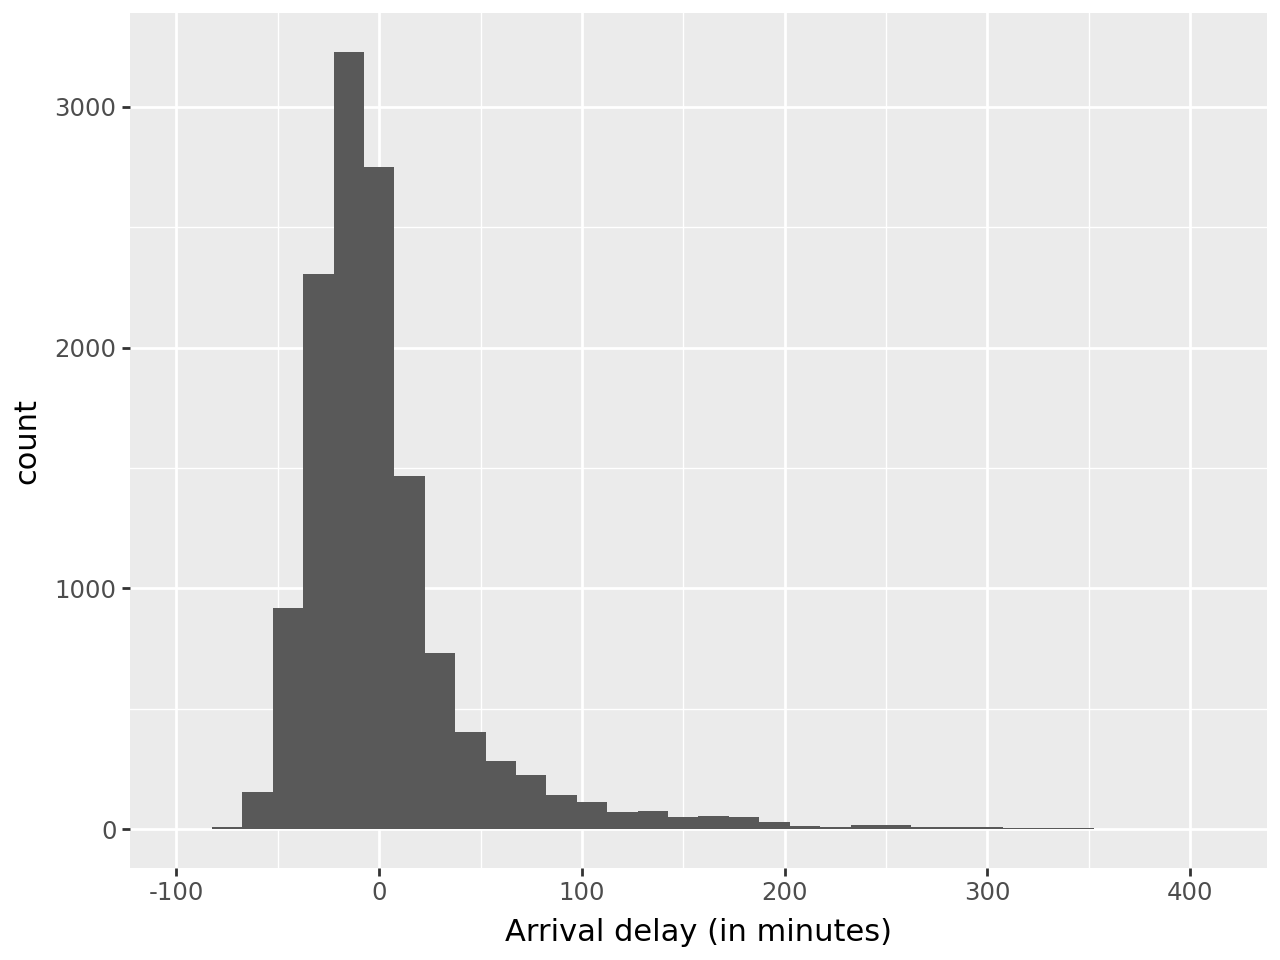

In [25]:
filtered_data = SF[SF['arr_delay'] < 420]
plot = (
    ggplot(filtered_data, aes(x='arr_delay')) +
    geom_histogram(binwidth=15) +
    labs(x='Arrival delay (in minutes)', y='count')
)

plot.show()

The months with the highest number of long delays were June (X6) and July (X7)— this could be due to the holiday season, weather, or airport congestion.

In [26]:
SF['long_delay'] = SF['arr_delay'] > 60

grouped = SF.groupby(['month', 'long_delay']).size().reset_index(name = 'n')
month_mapping = {1: 'X1', 2: 'X2', 3: 'X3', 4: 'X4', 5: 'X5', 6: 'X6',
                 7: 'X7', 8: 'X8', 9: 'X9', 10: 'X10', 11: 'X11', 12: 'X12'}
grouped['month'] = grouped['month'].map(month_mapping)

pivoted = grouped.pivot(index = 'long_delay', columns = 'month', values='n').reset_index()

column_order = ['long_delay'] + [f'X{i}' for i in range(1, 13)]
pivoted = pivoted.reindex(columns = column_order).fillna(0)
pivoted.index = pivoted.index + 1
pivoted.columns.name = None

print(pivoted)

   long_delay   X1   X2   X3   X4    X5   X6   X7    X8    X9   X10   X11  \
1       False  856  741  812  993  1128  980  966  1159  1124  1177  1107   
2        True   29   21   61  112    65  209  226    96    65    36    51   

    X12  
1  1093  
2    66  


UA (United Airlines) appears to have the most flights overall and also has the highest number of long delays (492).
However that could also be because they have a much larger flight volume than other airlines.

In [27]:
SF['long_delay'] = SF['arr_delay'] > 60
grouped = SF.groupby(['carrier', 'long_delay']).size().reset_index(name = 'n')
pivot = grouped.pivot(index = 'long_delay', columns = 'carrier', values = 'n').fillna(0).reset_index()
pivot.index = pivot.index + 1
pivot.columns.name = None
print(pivot)

   long_delay    AA   B6    DL    UA    VX
1       False  1250  934  1757  6236  1959
2        True   148   86    91   492   220


Peak flight hours are 7:00 and 10:00, with the most flights.

Delays tend to increase over time, likely due to the cumulative effect of previous flights (e.g. a plane arriving late and affecting the next flight).

Morning schedules (dawn to 8 am) are relatively safe to avoid delays.

In [28]:
grouped = SF.groupby('hour').size().reset_index(name = '1')

hour_mapping = {
    5: 'X5', 6: 'X6', 7: 'X7', 8: 'X8', 9: 'X9', 10: 'X10', 11: 'X11', 12: 'X12',
    13: 'X13', 14: 'X14', 15: 'X15', 16: 'X16', 17: 'X17', 18: 'X18', 19: 'X19',
    20: 'X20', 21: 'X21'
}
grouped['hour'] = grouped['hour'].map(hour_mapping)

pivot = grouped.pivot_table(index = None, columns = 'hour', values = '1', fill_value = 0)

column_order = [f'X{i}' for i in range(5, 22)]
pivot = pivot.reindex(columns = column_order).fillna(0)
pivot.columns.name = None
pivot = pivot.astype(int)
print(pivot)

   X5   X6    X7   X8   X9   X10  X11  X12  X13  X14  X15  X16   X17   X18  \
1  55  663  1696  987  429  1744  413  504  476  528  946  897  1491  1091   

   X19  X20  X21  
1  731  465   57  


The later the departure schedule, the higher the potential for delay.

Morning schedules (5–8 a.m.) tend to have lower and more stable delay distributions.

Outliers (black dots above) appear more in the afternoon–evening schedule.

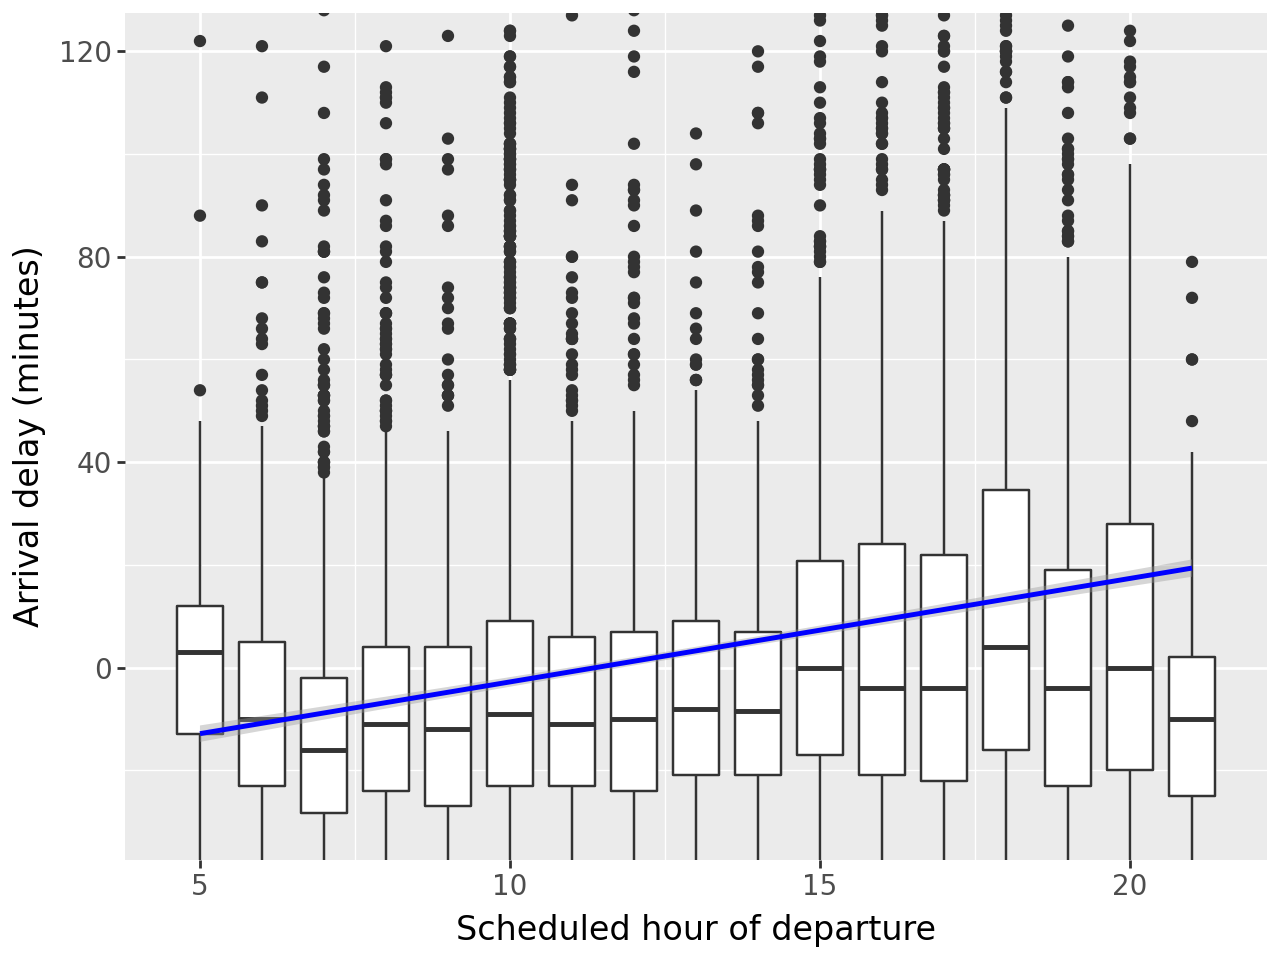

In [29]:
plot_SF = (
    ggplot(SF, aes(x = 'hour', y = 'arr_delay'))
    + geom_boxplot(aes(group = 'hour'))
    + geom_smooth(method = 'lm', color = 'blue')
    + xlab("Scheduled hour of departure")
    + ylab("Arrival delay (minutes)")
    + coord_cartesian(ylim = (-30, 120))
    + theme(
        axis_title = element_text(size = 12),
        axis_text = element_text(size = 10)
    )
)

# Display the plot
plot_SF.show()

Linear regression analysis is used to see the factors that influence aircraft arrival delays (arr_delay)
- If the plane departs exactly at 00:00, the model estimates that the plane will arrive 22.93 minutes earlier.
- Every 1 hour later departure → delay increases by 2.01 minutes.
- Std. Error: The smaller it is, the more precise the estimate is.
- Statistic (t-statistic): A measure of how far the coefficient is from zero statistically. A t-statistic of 22.01 is very high → meaning the hour effect is very strong.
- P-Value: The likelihood that the relationship between variables occurs simply by chance. A very small p-value (e.g. 1.78e-105) → means it is highly statistically significant.

In [30]:
model = smf.ols('arr_delay ~ hour', data = SF).fit()
results_df = pd.DataFrame({
    'term': model.params.index,
    'estimate': model.params.values,
    'std.error': model.bse.values,
    'statistic': model.tvalues,
    'p.value': model.pvalues
}).reset_index(drop = True)
results_df.index = results_df.index + 1
results_df['p.value'] = results_df['p.value'].apply(lambda x: '{:.2e}'.format(x))

print(results_df)

        term  estimate  std.error  statistic    p.value
1  Intercept    -22.93       1.23     -18.60   2.88e-76
2       hour      2.01       0.09      22.01  1.78e-105


- day: only date (without hour) from time_hour
- dow: day name (Monday, Tuesday, ...)
- season: if June/July → summer, otherwise → other month
- hour (departure time)
- origin (origin airport)
- carrier (airline)
- dow (day of the week)

In [31]:
SF['day'] = pd.to_datetime(SF['time_hour']).dt.date
SF['dow'] = SF['day'].apply(lambda x: x.strftime('%A'))
SF['season'] = SF['day'].apply(lambda x: 'summer' if x.month in [6, 7] else 'other month')

model_formula = 'arr_delay ~ hour + origin + carrier + season + dow'
mod2 = smf.ols(formula=model_formula, data=SF).fit()

- Intercept -24.64 Delay at baseline conditions (e.g. Monday, non-summer season, reference airline)
- Hour = 1 hour delay more → add 2.08 minutes delay
- OriginJFK = From JFK → 4.12 minutes slower than baseline origin
- CarrierDL = Delta Airlines is 18.41 minutes faster than reference airline
- Seasonsummer 25.27 Summer season → 25.27 minutes delay longer than other seasons

In [32]:
results_mod2 = pd.DataFrame({
    'term': mod2.params.index,
    'estimate': mod2.params.values,
    'std.error': mod2.bse.values,
    'statistic': mod2.tvalues,
    'p.value': mod2.pvalues
}).reset_index(drop = True)
results_mod2['term'] = results_mod2['term'].str.replace('C\(|\)|\[T\.|\]', '', regex = True)

hour_row = results_mod2[results_mod2['term'] == 'hour']
other_rows = results_mod2[results_mod2['term'] != 'hour']
results_mod2 = pd.concat([other_rows.iloc[:1], hour_row, other_rows.iloc[1:]]).reset_index(drop = True)

results_mod2['term'] = results_mod2['term'].replace({
    'dowMonday': 'dowMon',
    'dowTuesday': 'dowTue',
    'dowWednesday': 'dowWed',
    'dowThursday': 'dowThu',
    'dowFriday': 'dowFri',
    'dowSaturday': 'dowSat',
    'dowSunday': 'dowSun'
}, regex = True)

results_mod2.index = results_mod2.index + 1
results_mod2['p.value'] = results_mod2['p.value'].apply(lambda x: '{:.2e}'.format(x))


print(results_mod2)

            term  estimate  std.error  statistic    p.value
1      Intercept    -24.64       2.17     -11.33   1.32e-29
2           hour      2.08       0.09      23.18  1.47e-116
3      originJFK      4.12       1.00       4.10   4.21e-05
4      carrierB6    -10.32       1.88      -5.49   4.07e-08
5      carrierDL    -18.41       1.62     -11.40   5.90e-30
6      carrierUA     -4.76       1.48      -3.22   1.31e-03
7      carrierVX     -5.06       1.60      -3.17   1.54e-03
8   seasonsummer     25.27       1.03      24.51  1.00e-129
9         dowMon      1.74       1.45       1.21   2.28e-01
10        dowSat     -5.63       1.55      -3.64   2.75e-04
11        dowSun      5.12       1.48       3.47   5.32e-04
12        dowThu      3.19       1.45       2.20   2.78e-02
13        dowTue     -1.65       1.45      -1.14   2.53e-01
14        dowWed     -0.88       1.45      -0.61   5.42e-01


In [34]:
SF['carrier'].unique()

array(['UA', 'DL', 'VX', 'B6', 'AA'], dtype=object)